# Selecting the best colour cuts and colour stretch for Herschel-SPIRE maps

*Note:* the consideration in this notebook are useful for selecting generic method to select *automatically* the colour cuts and colour table stretch for Herschel-SPIRE images.

In most cases the method provides good results. For the best results on individual images, however, the user may want to play with the different options interactively.
    

## Outline

This is a brief outline of the method.

Pre-requisites:

* we use SPIRE extended-source calibrated maps, with map zero levels derived via cross-calibration with Planck-HFI all-sy maps. The units for those maps are MJy/sr. 
* We only consider maps at Level2_5 if they exist, otherwise we use Level2 maps.

Steps in method:

1. Find the mode of the pixel distribution of the map, this is the most frequent value on the map. We assume that the mode is representative of the background level.
2. Normalise the map using astropy.visualisation.ImageNormalize(). There are two important concepts in the image normalisation: *Interval* and *Stretch*
  * *Interval*: the interval defines the cuts, as known from other astro software i.e. which values on the map to use. Everything below or above the cuts is clipped.
  * *Stretch*: how to distribute the intensities from the valus in the *Interval*.

There are a number of available methods for selecting the interval values: MinMaxInterval, PercentileInterval, AsymmetricPercentileInterval

And there are a number of methods for selecting the stretch: SqrtStretch, LogStretch, LinearStretch, AsinhStretch

I have experimented with most of them, bit not toroughly. And the best seems to be:
 * AsymmetricPercentileInterval(mode,99.5)
 * AsinhStretch()

3. the I use matplotlib and plot the image.
4. I save the image as PNG
5. I read the PNG file and add the WCS keywords as metadata to the PNG file, at th esame time converting it to a greyscale PNG (makes the file twice smaller).

The PNG files with WCS keywords can be used in [HiPS](http://aladin.u-strasbg.fr/hips/) generation. To be confirmed...



In [2]:
#
# all the necessary imports
#
import requests
import os, io
import gzip
import tarfile
import warnings
import numpy as np

from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.visualization import (LogStretch, ImageNormalize, \
    PercentileInterval, AsymmetricPercentileInterval, SqrtStretch,\
    AsinhStretch)

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image, PngImagePlugin

%matplotlib inline

In [46]:
# global variables
home = os.path.expanduser('~')
#
# set the tmpDir to a sutable temprary place
#
for idir in [home+ "/tmp",home+"/Tmp",home+"/temp",home+"/Temp","/tmp"]:
    if (os.path.isdir(idir)):
        tmpDir = idir
        break
#
# or setting it up manually
#
tmpDir = home + '/Tmp/map_tests'
if (not os.path.isdir(tmpDir)):
    raise NameError("The temporary folder %s is needed but it does not exist. Please fix."%tmpDir)

## Function to get SPIRE level2 or level2_5 maps 

The function uses the [Herschel Science Archive](http://archives.esac.esa.int/hsa/whsa/) HIAO inteface, the API is available [here](https://archives.esac.esa.int/hsa/aio/doc/howto.html).

The function implements a simple caching system, checking the tmpDir location if VOTABLE and .tar file with a specific name is already available. You may need to clean those files from the tmpDir if you don't need them after running the notebook.

Note that by default the function download extended-source calibrated maps, you may want to change what='psrc' if you want to use the point-source calibrated maps. If you want to use the HiRes maps, maps deconvolved with the beam a-la Richardson-Lucy, then what='hires'.

It is important to realise that the downloaded .tar file contains all level2_5 (or level2) products. So, all 'extd', 'psrc' and 'hires' products are available (and also 'sso' point-source calibrated maps for solar system objects).


In [47]:
def getSpirePhotMaps(obsid, level='Level2', what="extd", cache=True):
    """
    Download VOTABLE with the metadata search
    Then save the products in a tar file and return the maps in a dictionary
    level - what level to extract, can be Level2, Level2_5 or Level3
    what - 'extd' for extended-source calibrated maps, 'psrc' for point-source
    cache - will check if votable or a tar files are already available in tmpDir
    
    """
    archiveMetaUrl = "http://archives.esac.esa.int/hsa/aio/jsp/metadata.jsp"
    archiveProdUrl = "http://archives.esac.esa.int/hsa/aio/jsp/product.jsp"
    #
    haioMetaRequest = "%s?RESOURCE_CLASS=OBSERVATION&INSTRUMENT=%%%%27SPIRE%%%%27&OBSERVATION_ID=%i"%(archiveMetaUrl,obsid)
    #print (haioMetaRequest)
    #
    voFile =  tmpDir + "/%i_metadata.vot"%obsid
    if (os.path.isfile(voFile)):
        print ("Found an already existing metadata VOTABLE file for OBSID %i. Will reuse it"%obsid)
    else:
        r = requests.get(haioMetaRequest)
        with open(voFile, "wb") as tmp:
            tmp.write(r.content)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        votable = parse_single_table(voFile, pedantic=False)
    #
    data = votable.array
    #
    procLevel = data['Obs_State'].data[0].decode()
    instMode = data["Instrument_mode"].data[0].decode()
    #
    if ('LEVEL3' in procLevel):
        print ("Observation %i has level-3 map"%obsid)
        levelx = 'Level3'
    elif ('LEVEL2_5' in procLevel):
        print ("Observation %i has level-2_5 map"%obsid)
        levelx = 'Level2_5'
    else:
        levelx = 'Level2'
    #
    print ("OBSID %i (%s) has %s"%(obsid,instMode,levelx) )
    print (" ===> you asked for %s"%level)
    #
    #
    tarFile = tmpDir + "/%i_%s_%s.tar"%(obsid,instMode,level)
    #
    #levelx = "Level2"
    if os.path.isfile(tarFile):
        print ("Found an already existing tar file for OBSID %i. Will Use it"%obsid)
    else:
        haioProdRequest = "%s?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=%s"%(archiveProdUrl,obsid, level)
        r = requests.get(haioProdRequest)
        if (b'No results' in r.content):
            print ("*** No results")
            return None
        else:
            with open(tarFile, "wb") as tmp:
                tmp.write(r.content)
    #
    maps = {}
    with tarfile.open(tarFile,'r') as tar:
        for member in tar.getmembers():
            if ((what in member.name) and (not 'diag' in member.name)):
                f=tar.extractfile(member)
                xx = fits.open(gzip.open(io.BytesIO(f.read())))
                band = xx[0].header["DETECTOR"]
                maps[band] = xx
    #
    return maps


## Function for visualising



In [97]:
def displaySpireMap(simpleImage, savePng=False, cuts=None, verbose=True):
    """
    The input is a simpleImage, i.e. the special FITS file from Herschel with 4 extensions:
    extension = 0 => containing the observation metadata 
    'image': the image
    'error': the error map
    'coverage': the coverage map
    there are more extensions but they are irrelevant
    
    to save to a PNG file with WCS metadata set savePng=True
    
    You can manually set the cuts as a list
    cuts = (10,99.5) to cut asymmetrically everything below the 10% and above 99.5% of 
    the intensity distribution
    """
    if ('OBJECT' in simpleImage[0].header.keys()):
        target = simpleImage[0].header['OBJECT']
    else:
        target = 'Unknown'
    #
    # extract some metadata keywords
    #
    if ('OBS_ID' in simpleImage[0].header.keys()):
        # for level2
        myObsid = simpleImage[0].header["OBS_ID"]
        sobsid = "%i"%myObsid
    else:
        # for level2_5 we pick up the first OBSID from the list of merged ones
        myObsid = simpleImage[0].header["OBSID001"]
        sobsid = "%i+"%myObsid # just for display, to indicate with ++ for level2_5
    band = simpleImage[0].header["DETECTOR"]
    #
    # the WCS from the image extension
    #
    wcsheader = simpleImage['image'].header
    #
    image = simpleImage['image'].data
    imx = image[~np.isnan(image)]
    min_image = np.min(imx)
    max_image = np.max(imx)
    #
    # now find the mode
    #
    mode = stats.mode(image,axis=None,nan_policy='omit')
    # normalized mode in percentage
    mode_x = 100*(mode.mode[0] - min_image)/(max_image - min_image)
    fig  = plt.figure(figsize=(10,10))
    #
    # select the cuts, either automatically with the mode or user-provided
    #
    if (cuts == None):
        intx = AsymmetricPercentileInterval(mode_x,99.5)
        if (verbose):
            print ("Using percentile cuts: %f, %f"%(mode_x,99.5))
    else:
        if (verbose):
            print ("Using percentile cuts: %f, %f"%(cuts[0],cuts[1]))
        intx = AsymmetricPercentileInterval(cuts[0],cuts[1])
    #
    # normalising the image, this is the most important step!
    #
    norm = ImageNormalize(image,interval=intx,stretch=AsinhStretch())
    #
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap=cm.gray, norm=norm, origin="lower", interpolation="nearest")
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])    
    #ax.annotate("%s, %s %s"%(target,sobsid,band), textcoords='axes fraction',fontsize=10, xy=(0.05,0.95),xytext=(0.05,0.95))
    plt.axis('off')
    if (savePng):
        pngFile = os.path.join(tmpDir,"%i_%s_plot.png"%(myObsid,band))
        #hhhFile = pngFile.replace('.png','.hhh')
        #simpleImage['image'].header.tofile(hhhFile,overwrite=True)
        plt.savefig(pngFile)
        #plt.savefig(pngFile, dpi=300)
        plt.close()
        #
        # now re-read the PNG and add metadata and convert to grayscale (mode='L')
        #
        im = Image.open(pngFile)
        meta = PngImagePlugin.PngInfo()
        #useMeta = ["NAXIS","NAXIS1","NAXIS2","CRPIX1","CRPIX2","CRVAL1","CRVAL2","CDELT1","CDELT2",
        #           "CTYPE1","CTYPE2","EQUINOX","CROTA2"]
        #ss = "SIMPLE = T\nBITPIX = 8\nNAXIS3 = 3\nCTYPE3 = 'RGB'\nRADECSYS = 'ICRS'\n"
        #for key in wcsheader.keys():
        #    if (key not in useMeta):
        #        continue
        #    ss += "%s=%s\n"%(key,wcsheader[key])
        meta.add_text('COMMENT',simpleImage['image'].header.tostring(sep='\n'))
        im.convert(mode='L').save(pngFile, "png", pnginfo=meta)
        #im.save(pngFile, "png", pnginfo=meta)
        #im.convert(mode='L').save(pngFile, "png")
        print ("Image saved to %s"%pngFile)
    else:
        plt.show()
    return True

In [49]:
#
# here is the usage with some interesting fields as examples
#
#myObsid = 1342193797 # NGC2841
#myObsid = 1342188750 # M101
#myObsid = 1342189508 # NGC1291
#myObsid = 1342189510 # NGC2915
myObsid = 1342182459 # M83
#myObsid = 1342182474 # B0420-014
#myObsid = 1342183050 # NGC6946
#myObsid = 1342183071 # GP-field1
#myObsid = 1342183496 # dark sky
#myObsid = 1342185644 # Lockman Hole
#myObsid = 1342186840 # DR21

mapx = getSpirePhotMaps(myObsid, level="Level2_5")
if (mapx == None):
    print ('You asked for level 2.5 but there isn\'t one. Will get level 2 instead')
    mapx = getPhotMaps(myObsid, level="Level2")
#


Found an already existing metadata VOTABLE file for OBSID 1342182459. Will reuse it
Observation 1342182459 has level-3 map
OBSID 1342182459 (SpirePhotoLargeScan) has Level3
 ===> you asked for Level2_5
Found an already existing tar file for OBSID 1342182459. Will Use it


Using percentile cuts: 2.931322, 99.500000


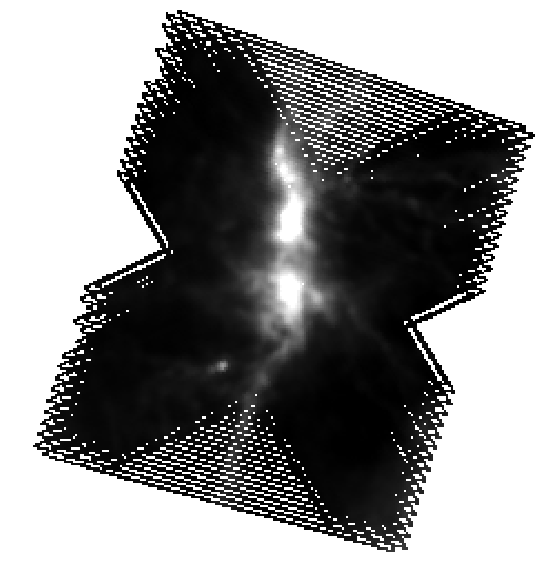

True

In [92]:
#
# the main driver, note that the three bands are already in memory, 
# so no need to re-download (ore re-read if cache=True) the tar file.
#
displaySpireMap(mapx['PSW'],savePng=False)

In [98]:
#
obsList = [1342188750,1342189508,1342189510,1342182459,1342182474,\
           1342183050,1342183071,1342183496,1342185644,1342186840]
for iobs in obsList:
    mapx = getSpirePhotMaps(iobs, level="Level2_5")
    if (mapx == None):
        print (' *** You asked for level 2.5 but there isn\'t one. Will get level 2 instead')
        mapx = getSpirePhotMaps(iobs, level="Level2")
    displaySpireMap(mapx['PSW'],savePng=True)
    print ("%i done"%iobs)
print ("ALL DONE")

Found an already existing metadata VOTABLE file for OBSID 1342188750. Will reuse it
Observation 1342188750 has level-3 map
OBSID 1342188750 (SpirePhotoLargeScan) has Level3
 ===> you asked for Level2_5
*** No results
 *** You asked for level 2.5 but there isn't one. Will get level 2 instead
Found an already existing metadata VOTABLE file for OBSID 1342188750. Will reuse it
Observation 1342188750 has level-3 map
OBSID 1342188750 (SpirePhotoLargeScan) has Level3
 ===> you asked for Level2
Found an already existing tar file for OBSID 1342188750. Will Use it
Using percentile cuts: 10.564513, 99.500000
Image saved to /Users/ivaltchanov/Tmp/map_tests/1342188750_PSW_plot.png
1342188750 done
Found an already existing metadata VOTABLE file for OBSID 1342189508. Will reuse it
OBSID 1342189508 (SpirePhotoLargeScan) has Level2
 ===> you asked for Level2_5
*** No results
 *** You asked for level 2.5 but there isn't one. Will get level 2 instead
Found an already existing metadata VOTABLE file for OB